# MNIST from scratch

In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

In [3]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [4]:
threes_img = (path/'train/3').ls().sorted()
threes_img

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [5]:
img_3 = Image.open(threes_img[1])
pd.DataFrame(tensor(img_3)).style.set_properties(**{'font-size' :'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


In [6]:
train_three_tns = [tensor(Image.open(o)) for o in (path/'train/3').ls().sorted()]
train_seven_tns = [tensor(Image.open(o)) for o in (path/'train/7').ls().sorted()]
len(train_three_tns), len(train_seven_tns)

(6131, 6265)

In [7]:
valid_three_tns = [tensor(Image.open(o)) for o in (path/'valid/3').ls().sorted()]
valid_seven_tns = [tensor(Image.open(o)) for o in (path/'valid/7').ls().sorted()]
len(valid_three_tns), len(valid_seven_tns)

(1010, 1028)

In [8]:
train_three_tns_stacked = torch.stack(train_three_tns)/255
train_seven_tns_stacked = torch.stack(train_seven_tns)/255
train_three_tns_stacked.shape, train_seven_tns_stacked.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

In [9]:
valid_three_tns_stacked = torch.stack(valid_three_tns)/255
valid_seven_tns_stacked = torch.stack(valid_seven_tns)/255
valid_three_tns_stacked.shape, valid_seven_tns_stacked.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

# Baseline

We just compare images to the average 3/7

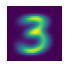

In [10]:
avg_3 = train_three_tns_stacked.mean(0)
show_image(avg_3);

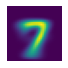

In [11]:
avg_7 = train_seven_tns_stacked.mean(0)
show_image(avg_7);

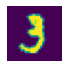

In [12]:
a_3 = train_three_tns_stacked[0]
show_image(a_3);

In [13]:
(a_3 - avg_3).abs().mean(), ((a_3 - avg_3)**2).mean().sqrt()

(tensor(0.1074), tensor(0.1912))

In [14]:
(a_3 - avg_7).abs().mean(), ((a_3 - avg_7)**2).mean().sqrt()

(tensor(0.1441), tensor(0.2780))

In [15]:
F.l1_loss(a_3.float(), avg_3), F.mse_loss(a_3, avg_3).sqrt()

(tensor(0.1074), tensor(0.1912))

In [16]:
def mnist_distance(a, b):
    return (a - b).abs().mean((-1, -2))

In [17]:
mnist_distance(a_3, avg_3)

tensor(0.1074)

Using broadcasting we can calculate the distance of all tensors

In [18]:
mnist_distance(valid_three_tns_stacked, avg_3)

tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260])

In [19]:
def is_3(x): 
    return mnist_distance(x, avg_3) < mnist_distance(x, avg_7)

In [20]:
is_3(a_3)

tensor(True)

In [21]:
accuracy_3 = is_3(valid_three_tns_stacked).float().mean()
accuracy_7 = 1 - is_3(valid_seven_tns_stacked).float().mean()
accuracy_baseline = (accuracy_3 + accuracy_7)/2
accuracy_baseline

tensor(0.9511)

# Training loop from scratch

Lets convert the rank-3 tensor in a rank-2 tensor

In [22]:
train_x = torch.cat([train_three_tns_stacked, train_seven_tns_stacked]).view(-1, 28*28)
train_y = (tensor(len(train_three_tns) * [1] + len(train_seven_tns) * [0])).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [23]:
valid_x = torch.cat([valid_three_tns_stacked, valid_seven_tns_stacked]).view(-1, 28*28)
valid_y = (tensor(len(valid_three_tns) * [1] + len(valid_seven_tns) * [0])).unsqueeze(1)
valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

Now we create a dataset, which is a datastructure that when indexed return a tuple (x, y), and than dataloaders, iterators over datasets

In [24]:
train_ds = list(zip(train_x, train_y))
valid_ds = list(zip(valid_x, valid_y))

train_dl = DataLoader(train_ds, batch_size=256)
valid_dl = DataLoader(valid_ds, batch_size=256)

In [25]:
def init_param(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

def linear1(xb):
    return xb@weights + bias

def mnist_loss(preds, targets):
    preds = preds.sigmoid()
    return torch.where(targets == 1, 1 - preds, preds).mean()

def calculate_gradient(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()
    
def train_epoch(model, lr, params):
    for xb, yb in train_dl:
        calculate_gradient(xb, yb, model)
        for p in params:
            p.data -= lr * p.grad
            p.grad.zero_()
            
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [26]:
# simple training loop
lr = 1.
weights = init_param((28*28, 1))
bias = init_param(1)
params = weights, bias

for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), ' ')

0.7104  
0.8657  
0.9223  
0.9438  
0.9536  
0.957  
0.9604  
0.9634  
0.9653  
0.9653  
0.9663  
0.9678  
0.9687  
0.9687  
0.9692  
0.9692  
0.9692  
0.9702  
0.9707  
0.9712  


# Simplify training loop with an optimizer

In [27]:
linear_model = nn.Linear(28*28, 1)
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [28]:
class BasicOptim:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr
    
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= self.lr * p.grad.data
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

opt = BasicOptim(linear_model.parameters(), lr)

def train_epoch(model):
    for xb, yb in train_dl:
        calculate_gradient(xb, yb, model)
        opt.step()
        opt.zero_grad()
        
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model))

In [29]:
linear_model = nn.Linear(28*28, 1)
lr = 0.1
opt = BasicOptim(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.5386
0.8662
0.9351
0.9541
0.9643
0.9648
0.9653
0.9673
0.9687
0.9697
0.9697
0.9697
0.9712
0.9712
0.9721
0.9721
0.9721
0.9726
0.9731
0.9731


# Use SGD instead of simple optimizer

In [30]:
linear_model = nn.Linear(28*28, 1)
lr = 0.1
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.5459
0.8677
0.9316
0.9507
0.9634
0.9638
0.9648
0.9668
0.9678
0.9682
0.9692
0.9697
0.9702
0.9712
0.9717
0.9717
0.9717
0.9717
0.9717
0.9717


# Use the Learner from fastai

In [31]:
dls = DataLoaders(train_dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(10, lr=0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.226817,0.373488,0.544161,00:00
1,0.125178,0.188020,0.867027,00:00
2,0.085239,0.109981,0.933268,00:00
3,0.066292,0.081580,0.950932,00:00
4,0.056149,0.067757,0.964671,00:00
5,0.050084,0.059665,0.964181,00:00
6,0.046065,0.054344,0.965162,00:00
7,0.043165,0.050561,0.966634,00:00
8,0.040930,0.047718,0.966634,00:00
9,0.039126,0.045492,0.968597,00:00


# Deep Learning 🥸

In [32]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

dls = DataLoaders(train_dl, valid_dl)
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(40, lr=0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.274133,0.415487,0.505397,00:00
1,0.133235,0.219417,0.815505,00:00
2,0.075990,0.113271,0.913641,00:00
3,0.051320,0.077650,0.940137,00:00
4,0.039670,0.061077,0.954367,00:00
5,0.033588,0.051657,0.964181,00:00
6,0.030011,0.045682,0.965162,00:00
7,0.027635,0.041581,0.966634,00:00
8,0.025896,0.038586,0.969087,00:00
9,0.024538,0.036291,0.969578,00:00


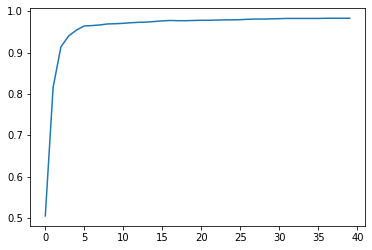

In [33]:
plt.plot(L(learn.recorder.values).itemgot(2));

# Using Fastai

In [34]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, arch=resnet18, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.133827,0.016789,0.996075,00:16
